# Making a package for systematics analysis

The idea of this notebook is to take a fully-converged MCMC fit and produce a package of data files suitable for analyzing the unmodelled systematics remaining in the data. It should contain:

* The best-fit parameter names, values, and uncertainties (covariance matrix)
* Names, values, and uncertainties on any parameters obtained by linear fitting
* Names, values, and uncertainties for derived parameters
* The astrometric parameters that went into the calculation
* The settings used in the fitting
* Residuals of the fitting, in the form of a matrix with columns time, residual (phase), uncertainty
* Derivatives of the residuals with respect to all fitted parameters
* Derivatives of an imaginary uniformly sampled data set with respect to all fitted parameters


In [1]:
%load_ext autoreload

%autoreload 2

In [37]:
from glob import glob
import os
import time
import cPickle as pickle
import joblib

import scipy.linalg
import scipy.stats

import emcee
import numdifftools

import kepler
import threebody

In [3]:
import matplotlib
matplotlib.rcParams['savefig.dpi'] = 144
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.viridis()

In [4]:
jobid = "69543" # general-purpose fit 2016-09-26

job_dir = glob(os.path.join("emcee-chains",jobid+".*"))[0]

In [21]:
fpname = os.path.join(job_dir,"fitter_params.pickle")
with open(fpname) as f:
    fitter_params = pickle.load(f)
F = threebody.Fitter(**fitter_params)
fitter_params

{'efac': (('AO1440', 1.45), ('GBT1500', 1.11), ('WSRT1400', 1.45)),
 'files': '0337+17-anne-2014-09-22',
 'fit_pm': True,
 'fit_pos': True,
 'fit_px': True,
 'kopeikin': False,
 'parfile': '0337_tempo2_px_optical.par',
 'ppn_mode': 'heavysimple',
 'priors': ('dbeta', 'dgamma'),
 't2_astrometry': True,
 'tzrmjd_middle': 'auto'}

In [22]:
F.best_parameters

{'acosi_i': 1.490864525602941249,
 'acosi_o': 91.462105554266682511,
 'asini_i': 1.2175235081796686404,
 'asini_o': 74.672544310979061546,
 'd_DECJ': 3.3050798540273973234e-07,
 'd_PMDEC': 5.4403826076983394793e-10,
 'd_PMRA': -1.224736370376197594e-10,
 'd_PX': 0.15710245741800645675,
 'd_RAJ': -5.7752544509839158945e-08,
 'dbeta': 0.000250833950569257465,
 'delta': -2.5970266603457313364e-06,
 'delta_lan': 2.5022316857693132417e-06,
 'dgamma': -9.4478725480577677947e-07,
 'eps1_i': 0.00068979836665728518929,
 'eps1_o': 0.035185583643610913349,
 'eps2_i': -9.1393421554759699492e-05,
 'eps2_o': -0.0034643324573668049336,
 'f0': 365.95336311711874974,
 'j_AO1350': 5.364017648361716e-05,
 'j_AO1440': -0.00055109428107106126673,
 'j_AO327': 6.457616019511097e-05,
 'j_GBT1500': -0.00053765614592136709088,
 'j_GBT350': 1.8912917353649655e-05,
 'j_GBT820': 6.712253154451129e-05,
 'j_NCY1400': 0.000675,
 'j_WSRT350': -3.6063906052781444e-05,
 'pb_i': 1.6293884869124945255,
 'pb_o': 327.256016

In [23]:
orbit = F.compute_orbit(F.best_parameters)
orbit

{'initial_values': array([  1.13425600e+02,   2.15795406e+01,   1.76181135e+01,
          6.76147247e+00,   1.69370540e+00,   1.38279317e+00,
          1.43651336e+00,   1.13423383e+02,   3.39242096e+01,
          2.76994619e+01,  -5.46138697e+01,   1.69143623e+00,
          1.38094004e+00,   1.97472434e-01,  -4.51970716e+02,
         -9.19337169e+01,  -7.50585060e+01,   2.61373132e+00,
         -6.74788678e+00,  -5.50918200e+00,   4.10060596e-01,
          0.00000000e+00]),
 'n_evaluations': 788948,
 'parameter_dict': {'acosi_i': 1.490864525602941249,
  'acosi_o': 91.462105554266682511,
  'asini_i': 1.2175235081796686404,
  'asini_o': 74.672544310979061546,
  'd_DECJ': 3.3050798540273973234e-07,
  'd_PMDEC': 5.4403826076983394793e-10,
  'd_PMRA': -1.224736370376197594e-10,
  'd_PX': 0.15710245741800645675,
  'd_RAJ': -5.7752544509839158945e-08,
  'dbeta': 0.000250833950569257465,
  'delta': -2.5970266603457313364e-06,
  'delta_lan': 2.5022316857693132417e-06,
  'dgamma': -9.4478725480

33726.3431736 34570


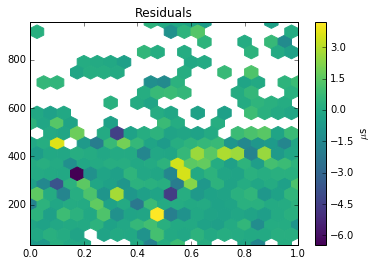

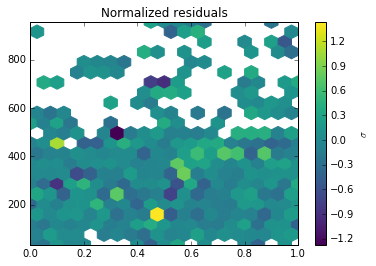

In [24]:
residuals = F.residuals()
plt.hexbin(
    ((F.mjds-F.base_mjd-F.best_parameters['tasc_i'])/F.best_parameters['pb_i'])%1, 
    F.mjds,
    C=residuals/F.best_parameters['f0']*1e6, gridsize=20)
plt.title("Residuals")
plt.colorbar().set_label(r"$\mu$s")
plt.figure()
plt.hexbin(
    ((F.mjds-F.base_mjd-F.best_parameters['tasc_i'])/F.best_parameters['pb_i'])%1, 
    F.mjds,
    C=residuals/F.phase_uncerts, gridsize=20)
plt.title("Normalized residuals")
plt.colorbar().set_label(r"$\sigma$")

print np.sum((residuals/F.phase_uncerts)**2), len(F.mjds)

In [31]:
M, linear_parameters = F.compute_linear_matrix()
linear_parameters

['tzrmjd', 'f0', 'f1']

In [32]:
M.shape

(34570, 3)

In [33]:
derivatives = {}

In [34]:
for i, p in enumerate(linear_parameters):
    derivatives[p] = M[:,i]

In [53]:
def fres(p):
    print p
    bp  = F.best_parameters.copy()
    for (i,fp) in enumerate(F.parameters):
        bp[fp] += p[i]
    r = F.residuals(bp)
    return r
x = np.zeros(len(F.parameters))
J = numdifftools.Jacobian(fres)(x)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.]
[ 0.04  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
[-0.04  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
[ 0.02  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
[-0.02  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
[ 0.01  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
[-0.01  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
[ 0.005  0.     0.     0.     0

In [55]:
for (i,p) in enumerate(F.parameters):
    derivatives[p] = J[:,i]

In [58]:
np.savez_compressed(
    "systematics-package.npz",
    fitter_params=fitter_params,
    best_parameters=F.best_parameters,
    residuals=residuals,
    telescopes=F.tels,
    telescope_list=F.tel_list,
    orbit=orbit,
    times=F.mjds,
    base_mjd=F.base_mjd,
    phase_uncerts=F.phase_uncerts,
    linear_parameters=linear_parameters,
    derivatives=derivatives,
    )

In [47]:
numdifftools.Derivative?

In [71]:
d = dict(
    fitter_params=fitter_params,
    best_parameters=F.best_parameters,
    residuals=residuals,
    telescopes=F.tels,
    telescope_list=F.tel_list,
    raw_uncerts=F.raw_uncerts,
    f0=F.best_parameters['f0'],
    efacs=fitter_params['efac'],
    orbit=orbit,
    times=F.mjds,
    base_mjd=F.base_mjd,
    phase_uncerts=F.phase_uncerts,
    linear_parameters=linear_parameters,
    derivatives=derivatives,
    )
with open("systematics-package.pickle","wb") as f:
    pickle.dump(d,f)

In [63]:
dir(F)

[autoreload of numpy.compat failed: Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: cannot import name _inspect
]
[autoreload of numpy.core failed: Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: cannot import name multiarray
]
[autoreload of numpy failed: Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: cannot import name add_newdocs
]
[autoreload of numpy.fft failed: Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportErro

['__class__',
 '__delattr__',
 '__dict__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__hash__',
 '__init__',
 '__module__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'args',
 'base_mjd',
 'best_errors',
 'best_parameters',
 'bootstrap',
 'chi2',
 'compute_linear_matrix',
 'compute_linear_parts',
 'compute_orbit',
 'derivs',
 'dof',
 'efac',
 'files',
 'fit',
 'fit_pm',
 'fit_pos',
 'fit_px',
 'general',
 'ix',
 'jmatrix',
 'jnames',
 'kopeikin',
 'last_orbit',
 'last_p',
 'linear_jumps',
 'lnprior',
 'lnprob',
 'make_mfun',
 'matrix_mode',
 'mjds',
 'parameters',
 'parfile',
 'phase_uncerts',
 'ppn_mode',
 'priors',
 'pulses',
 'raw_uncerts',
 'residuals',
 'shapiro',
 'special',
 't2_astrometry',
 'tel_base',
 'tel_list',
 'tels',
 'tol',
 'tzrmjd_base',
 'uncerts',
 'use_quad']

In [67]:
F.phase_uncerts/(F.best_parameters['f0']*F.raw_uncerts)

array([ 1.11,  1.11,  1.11, ...,  1.11,  1.11,  1.11])

In [70]:
fitter_params

{'efac': (('AO1440', 1.45), ('GBT1500', 1.11), ('WSRT1400', 1.45)),
 'files': '0337+17-anne-2014-09-22',
 'fit_pm': True,
 'fit_pos': True,
 'fit_px': True,
 'kopeikin': False,
 'parfile': '0337_tempo2_px_optical.par',
 'ppn_mode': 'heavysimple',
 'priors': ('dbeta', 'dgamma'),
 't2_astrometry': True,
 'tzrmjd_middle': 'auto'}

In [69]:
F.efac

1.0